In [235]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
import statsmodels.api as sm
import sys
from stocktrends import Renko

In [236]:
# !{sys.executable} -m pip install stocktrends

In [237]:
start_date = '20181204'
# end_date = '20191101'
end_date = time.strftime("%Y%m%d")

In [238]:
url ="https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=" + start_date + "&end=" + end_date
example_df = pd.read_html(url)

data = example_df[2]
df =pd.DataFrame(data)

df['Date'] =  pd.to_datetime(df['Date']) # date
df.columns = ['Date','Open','High','Low','Close','Volume','Market Cap']
df.set_index('Date',inplace=True)
df.sort_index(inplace=True)
# df['log_ret'] = np.log(df['Close'] / df['Close'].shift(1))
# df['return'] = df['Close'].pct_change(1)
# df['vola'] = df['return'].rolling(15).std()*(360**0.5)*100

# Tech Indicators

### MACD

In [239]:
def MACD(DF, a, b, c):
    df = DF.copy()
    df['MA_Fast'] = df['Close'].ewm(span=a, min_periods=a).mean()
    df['MA_Slow'] = df['Close'].ewm(span=b, min_periods=b).mean()
    df['MACD'] = df['MA_Fast'] - df['MA_Slow']
    df['signal'] = df['MACD'].ewm(span=c, min_periods=c).mean()
    df.loc[:, ['Close', 'MACD', 'signal']].plot(figsize=(10,5));
    return df.dropna().head(2)

,Open,High,Low,Close,Volume,Market Cap,MA_Fast,MA_Slow,MACD,signal
Date,,,,,,,,,,
2019-01-01,3746.71,3850.91,3707.23,3843.52,4324200990,67098634181,3843.52,3778.721644,64.798356,62.550298
2019-01-02,3849.22,3947.98,3817.41,3943.41,5244856836,68849856732,3943.41,3794.603478,148.806522,81.876699


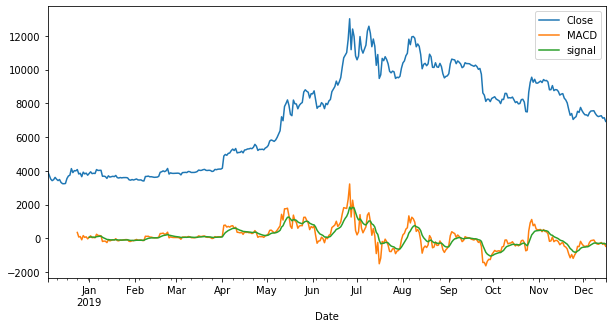

In [240]:
MACD(df, 1, 21, 9)

### ATR and Bollinger Bands

In [241]:
def ATR(DF, n):
    df = DF.copy()
    df['H-L'] = abs(df['High'] - df['Low'])
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1, skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
#     df['ATR'] = df['TR'].ewm(span=n, adjust=False, min_periods=n).mean()
    df2 = df.drop(['H-L', 'H-PC', 'L-PC'], axis=1).dropna()
    return df2.tail(5)

In [242]:
ATR(df, 9)['ATR']

C:\Users\ioshe\Anaconda3\envs\catalyst\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


Date
2019-12-12    213.088889
2019-12-13    179.486667
2019-12-14    146.251111
2019-12-15    157.571111
2019-12-16    180.154444
Name: ATR, dtype: float64

In [243]:
def BollBands(DF, n):
    df = DF.copy()
    df['MA'] = df['Close'].rolling(n).mean()
    df['BB_up'] = df['MA'] + 2 * df['MA'].rolling(n).std()
    df['BB_down'] = df['MA'] - 2 * df['MA'].rolling(n).std()
    df['BB_width'] = df['BB_up'] - df['BB_down']
    df.dropna(inplace=True)
    df.iloc[-100:, [-4, -3, -2]].plot()
    return df

,Open,High,Low,Close,Volume,Market Cap,MA,BB_up,BB_down,BB_width
Date,,,,,,,,,,
2019-12-15,7124.24,7181.08,6924.38,7152.30,16881129804,129481424648,7383.2300,7972.853129,6793.606871,1179.246258
2019-12-16,7153.66,7171.17,6903.68,6932.48,20213265950,125515586952,7368.9355,7910.308575,6827.562425,1082.746149


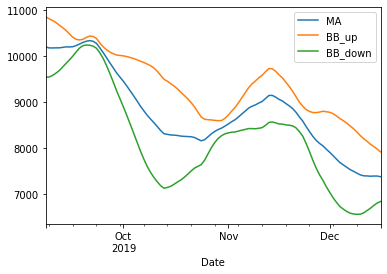

In [244]:
BollBands(df, 20).tail(2)

### RSI

In [245]:
def RSI(DF, n):
    df = DF.copy()
    df['delta'] = df['Close'] - df['Close'].shift(1)
    df['gain'] = np.where(df['delta'] > 0, df['delta'], 0)
    df['loss'] = np.where(df['delta'] < 0, abs(df['delta']), 0)
    avg_gain = []
    avg_loss = []
    gain = df['gain'].tolist()
    loss = df['loss'].tolist()
    for i in range(len(df)):
        if i < n:
            avg_gain.append(np.NaN)
            avg_loss.append(np.NaN)
        elif i == n:
            avg_gain.append(df['gain'].rolling(n).mean().tolist()[n])
            avg_loss.append(df['loss'].rolling(n).mean().tolist()[n])
        elif i > n:
            avg_gain.append(((n-1) * avg_gain[i-1] + gain[i]) / n)
            avg_loss.append(((n-1) * avg_loss[i-1] + loss[i]) / n)
            
    df['avg_gain'] = np.array(avg_gain)
    df['avg_loss'] = np.array(avg_loss)
    df['RS'] = df['avg_gain'] / df['avg_loss']
    df['RSI'] = 100 - (100 / (1+df['RS']))
    return df['RSI']

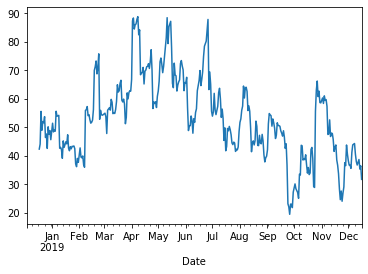

In [246]:
RSI(df, 14).plot();

### ADX Average Directional Index 

In [247]:
def ATR(DF, n):
    "function to calc True range and Average True Range"
    df = DF.copy()
    df['H-L'] = abs(df['High'] - df['Low'])
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1, skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
#     df['ATR'] = df['TR'].ewm(span=n, adjust=False, min_periods=n).mean()
    df2 = df.drop(['H-L', 'H-PC', 'L-PC'], axis=1)
    return df2

In [304]:
ATR(df, 14).head(50)

,Open,High,Low,Close,Volume,Market Cap,TR,ATR
Date,,,,,,,,
2018-12-04,3886.29,4075.63,3832.75,3956.89,5028069239,68878292608,NaN,NaN
2018-12-05,3958.89,3969.54,3753.99,3753.99,5302481574,65352496336,215.55,NaN
2018-12-06,3754.07,3874.97,3521.10,3521.10,5878333109,61303965508,353.87,NaN
2018-12-07,3512.59,3512.59,3280.23,3419.94,6835615448,59547645578,240.87,NaN
2018-12-08,3421.91,3506.04,3350.65,3476.11,5305024497,60531278392,155.39,NaN
2018-12-09,3473.23,3685.31,3469.09,3614.23,4947372847,62942160928,216.22,NaN
2018-12-10,3612.05,3647.33,3470.14,3502.66,5020968740,61004445982,177.19,NaN
2018-12-11,3497.55,3513.18,3392.25,3424.59,4696765188,59650201102,120.93,NaN
2018-12-12,3421.46,3534.23,3413.48,3486.95,4139364829,60741625426,120.75,NaN


In [248]:
def ADX(DF, n):
    "function to calc ADX"
    df2 = DF.copy()
    df2['TR'] = ATR(df2, n)['TR']
    df2['DMplus'] = np.where((df2['High'] - df2['High'].shift(1)) > (df2['Low'].shift(1) - df2['Low']), 
                             df2['High'] - df2['High'].shift(1), 0)
    df2['DMplus'] = np.where(df2['DMplus'] > 0, 0, df2['DMplus'])
    df2['DMminus'] = np.where((df2['Low'].shift(1) - df2['Low']) >  df2['High'] - df2['High'].shift(1), 
                              df2['Low'].shift(1) - df2['Low'], 0)
    df2['DMminus'] = np.where(df2['DMminus'] < 0, 0, df2['DMminus'])
    
    TRn = []
    DMplusN = []
    DMminusN = []
   
    TR = df2['TR'].tolist()
    DMplus = df2['DMplus'].tolist()
    DMminus = df2['DMminus'].tolist()
    for i in range(len(df2)):
        if i < n:
            TRn.append(np.NaN)
            DMplusN.append(np.NaN)
            DMminusN.append(np.NaN)
        elif i  ==  n:
            TRn.append(df2['TR'].rolling(n).sum().tolist()[n])
            DMplusN.append(df2['DMplus'].rolling(n).sum().tolist()[n])
            DMminusN.append(df2['DMminus'].rolling(n).sum().tolist()[n])
        elif i > n:
            TRn.append(TRn[i-1] - (TRn[i-1]/n) + TR[i])
            DMplusN.append(DMplusN[i-1] - (DMplusN[i-1]/n) + DMplus[i])
            DMminusN.append(DMminusN[i-1] - (DMminusN[i-1]/n) +DMminus[i])
    df2['TRn'] = np.array(TRn)
    df2['DMplusN'] = np.array(DMplusN)
    df2['DMminusN'] = np.array(DMminusN)
    
    df2['DIplusN'] = 100 * (df2['DMplusN'] / df2['TRn'])
    df2['DIminusN'] = 100 * (df2['DMminusN'] / df2['TRn'])
    
    df2['DIdiff'] = abs(df2['DIplusN'] - df2['DIminusN'])
    df2['DIsum'] = df2['DIplusN'] + df2['DIminusN']
    df2['DX'] = 100 * (df2['DIdiff'] / df2['DIsum'])
    
    ADX = []
    DX = df2['DX'].tolist()
    for j in range(len(df2)):
        if j < 2 * n - 1:
            ADX.append(np.NaN)
        elif j == 2*n - 1:
            ADX.append(df2['DX'][j -n+1:j+1].mean())
        elif j > 2 * n - 1:
            ADX.append(((n-1) * ADX[j-1] + DX[j])/n)
    df2['ADX'] = np.array(ADX)
    return df2['ADX']

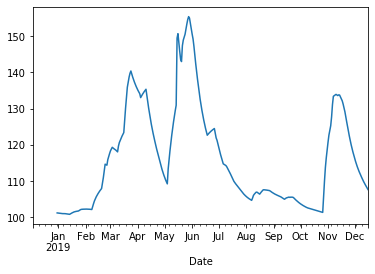

In [249]:
ADX(df, 14).plot();

### OBV On Balance Volume 
#### (momentum leading indicator)

In [250]:
def OBV(DF):
    df = DF.copy()
    df['daily return'] = df['Close'].pct_change()
    df['direction'] = np.where(df['daily return'] > 0, 1, -1)
    df['direction'][0] = 0
    df['vol_adj'] = df['Volume'] * df['direction']
    df['obv'] = df['vol_adj'].cumsum()
    return df['obv']

C:\Users\ioshe\Anaconda3\envs\catalyst\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


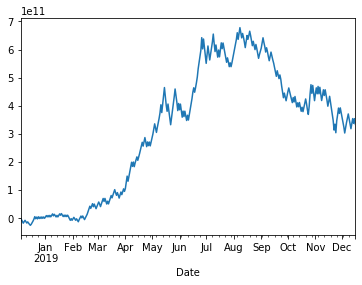

In [251]:
OBV(df).plot();

### Slope in the chart

In [252]:
def slope(DF, n):
    df  =DF.copy()
    "function to calc the slope of the consecutive on a plot"
    ser = df['Close']
    slopes = [i * 0 for i in range(n-1)]
    for i in range(n, len(ser) + 1):
        y = ser[i-n:i]
        x = np.array(range(n))
        y_scaled = (y - y.min()) / (y.max() - y.min())
        x_scaled = (x - x.min()) / (x.max() - x.min())
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled, x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = np.rad2deg(np.arctan(np.array(slopes)))
    df['slope'] = np.array(slope_angle)
    df
    df.loc[:, ['Close', 'slope']].plot(figsize=(12,4), subplots=True, layout = (2, 1))
    return np.array(slope_angle)[1:10]

array([  0.        ,   0.        ,   0.        , -43.98439282,
       -21.23495959,  17.95607125,   4.22118692, -19.5077727 ,
       -39.38285797])

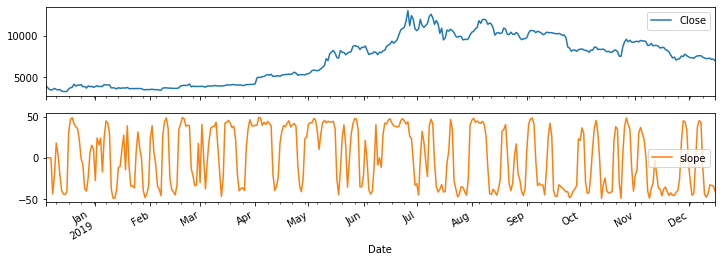

In [253]:
slope(df, 5)

### Renko charts

In [267]:
def ATR(DF, n):
    "function to calc True range and Average True Range"
    df = DF.copy()
    df['H-L'] = abs(df['High'] - df['Low'])
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1, skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
#     df['ATR'] = df['TR'].ewm(span=n, adjust=False, min_periods=n).mean()
    df2 = df.drop(['H-L', 'H-PC', 'L-PC'], axis=1)
    return df2

In [299]:
def renko_df(DF, n):
    df = DF.copy()
    df.reset_index(inplace=True)
    df = df.iloc[:, [0, 1, 2, 3, 4]]
    df.columns = ['date', 'open', 'high', 'low', 'close']
    renko_df = Renko(df)
    renko_df.brick_size = round(ATR(DF, n)['ATR'][-1])
    df2  = renko_df.get_ohlc_data()
    return df2

In [307]:
renko_df(df, 5).head(2)

,date,open,high,low,close,uptrend
0,2018-12-04,3620.0,3801.0,3620.0,3801.0,True
1,2018-12-07,3620.0,3620.0,3439.0,3439.0,False
